<h1> ______________________________________ </h1>

<h1> Full NEXT100 with fiber panels simulation mapping analysis </h1>
<h1> ______________________________________ </h1>

<p style="font-size: 17px; color: black;"> In this Notebook we take as input the maps created in the previous notebook and use it to simulate an s2 signal for bb0nu events. </p>




<h1> ____________ </h1>
<h2> This version </h2>
<h1> ____________ </h1>

-  <p style="font-size: 17px; color: black;"> 1 bb0nu event. </p>
-  <p style="font-size: 17px; color: black;"> Mapping separated by sensors. </p>

-  <p style="font-size: 17px; color: black;"> Geant4 fundamental units: </p>

 -  <p style="font-size: 17px; color: black;"> Length [L]: mm (milimeter) </p>
 -  <p style="font-size: 17px; color: black;"> Time [T]: ns (nanosecond) </p>
 -  <p style="font-size: 17px; color: black;"> Energy [E]: MeV (megaelectronvolt) </p>





In [1]:
import numpy              as np
import pandas             as pd

import scipy              
from scipy                import stats, integrate
from scipy.signal         import convolve

import matplotlib.pyplot  as plt

from matplotlib.ticker    import FormatStrFormatter # to set the format of the plot's axis
from matplotlib.patches   import Rectangle # To add blanck spaces in tabular legends

import os
import math
import tables             as tb

<h1> __________________________ </h1>
<h2> Read files </h2>

-  <p style="font-size: 17px; color: black;"> <b> S2 table </b> </p>

In [2]:
path = '/home/investigator/mariandbt/python/data'
path = path + '/20231025_NEXT100_full_mapping'

filename = os.path.join(path, "s2_table.h5")


# with tb.open_file(filename) as file:
#     print(file)

In [3]:
import h5py

# Load the 3D dictionary from the HDF5 file
loaded_data_dict = {}

columns = {0:'bin_initial_x',
           1:'bin_final_x',
           2:'bin_initial_y',
           3:'bin_final_y',
           4:'s2'
          }

with h5py.File(filename, 'r') as file:
    for table_id in file.keys():
        # Get the column names from the HDF5 attributes
        loaded_data_dict[table_id] = pd.DataFrame(file[table_id][:])
        loaded_data_dict[table_id].rename(columns = columns, inplace=True)



In [4]:
s2_table = loaded_data_dict.copy()

In [5]:
# s2_table.keys()

-  <p style="font-size: 17px; color: black;"> <b> bb0nu </b> </p>

In [6]:
path = '/home/investigator/mariandbt/python/data'
path = path + '/20231025_NEXT100_full_mapping'

filename = os.path.join(path, "Next100_bb.next.h5")


In [7]:
with tb.open_file(filename) as file:
    print(file)

/home/investigator/mariandbt/python/data/20231025_NEXT100_full_mapping/Next100_bb.next.h5 (File) ''
Last modif.: '2023-12-04T17:20:09+00:00'
Object Tree: 
/ (RootGroup) ''
/MC (Group) ''
/MC/configuration (Table(46,)) ''
/MC/hits (Table(810,)) ''
/MC/particles (Table(109720,)) ''
/MC/sns_positions (Table(136,)) ''
/MC/sns_response (Table(1445,)) ''



In [8]:
# %%timeit # WITH THIS YOU'RE ONLY TIMING, BUT IT DOESN'T REALLY RUN THE COMMANDS YOU TIME
bb_sensors = pd.read_hdf(filename, "/MC/sns_positions")
bb_data = pd.read_hdf(filename, "/MC/sns_response")
bb_particles = pd.read_hdf(filename, "/MC/particles")


In [9]:
bb_dst_particle = bb_particles.copy()
bb_sens = bb_sensors.copy()
bb_dst = bb_data.copy()


In [10]:
# we select the positions of the sensors at the end of the fibers
fiber_sens_mask = bb_sens.loc[bb_sens.sensor_name == 'F_SENSOR'].sensor_id # ID mask of the sensors at the end of the fibers
sens_fibers = bb_sens.loc[bb_sens.sensor_id.isin(fiber_sens_mask)].copy() # get the positions of said sensors


In [11]:
# we select the information of the ionization electrons only
bb_ie = bb_dst_particle.loc[bb_dst_particle.particle_name == 'ie-'].copy()


In [12]:
# pp = '/home/investigator/mariandbt/python/data'
# pp = pp + '/20231025_NEXT100_full_mapping'
# flnm = os.path.join(pp, "Next100_full_mapp_s2_inicioEL_100Kev.next.h5")
# sens = pd.read_hdf(flnm, "/MC/sns_positions")

# # we select the positions of the sensors at the end of the fibers
# fiber_sens_mask = sens.loc[sens.sensor_name == 'F_SENSOR'].sensor_id # ID mask of the sensors at the end of the fibers
# sens_fibers = sens.loc[sens.sensor_id.isin(fiber_sens_mask)] # get the positions of said sensors


<h1> __________________________ </h1>
<h2> Global parameters </h2>

In [13]:
n_panels = 18
n_sensors = 90
dtheta = 2*np.pi/n_panels # rad

dpos = int(n_sensors/n_panels) # number of sensors in 1 panel


In [14]:
# s2 map specs

s2_tab = s2_table[f'sens_200'] # all maps have the same specs, so we get whichever

x_nbins, y_nbins = len(s2_tab.bin_initial_x.unique()), len(s2_tab.bin_initial_y.unique())

x_bin_width = (s2_tab.bin_final_x - s2_tab.bin_initial_x)[0]
y_bin_width = (s2_tab.bin_final_y - s2_tab.bin_initial_y)[0]

x_min = s2_tab.bin_initial_x.min()
y_min = s2_tab.bin_initial_y.min()


<h1> __________________________ </h1>
<h2> Functions </h2>



In [15]:
def sens_map(selected_id):
    
    # we select the response of the sensors at the end of the fibers
    pp = '/home/investigator/mariandbt/python/data'
    pp = pp + '/20231025_NEXT100_full_mapping'

    flnm = os.path.join(pp, "Next100_full_mapp_s2_inicioEL_100Kev.next.h5")
    sens = pd.read_hdf(flnm, "/MC/sns_positions")
    dst_particle = pd.read_hdf(flnm, "/MC/particles")

    fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(10,10), constrained_layout=True)
    
    ax.plot(dst_particle.initial_x, dst_particle.initial_y, 'o')


    fiber_sens_mask = sens.loc[sens.sensor_name == 'F_SENSOR'].sensor_id # ID mask of the sensors at the end of the fibers

    sens_fibers = sens.loc[sens.sensor_id.isin(fiber_sens_mask)] # get the positions of said sensors

    font_size = 11
    ax.plot(sens_fibers.x, sens_fibers.y, 'o', markersize = 2*font_size)

    for sens_id in sens_fibers.sensor_id:
        xx = float(sens_fibers.loc[sens_fibers.sensor_id == sens_id].x)
        yy = float(sens_fibers.loc[sens_fibers.sensor_id == sens_id].y)

        ax.annotate(f'{sens_id:.0f}', (xx, yy),
                    color='black', ha='center', va='center', fontsize = font_size)

    if selected_id in sens_fibers.sensor_id.values:
        ax.plot(sens_fibers.loc[sens_fibers.sensor_id == selected_id].x, 
                sens_fibers.loc[sens_fibers.sensor_id == selected_id].y, 'o', 
                markersize = 2*font_size, label = 'Selected sensor')

        ax.legend(loc = (.4, .6))

    else:
        ax.annotate('Not (valid) sensor ID selected', (0, 100),
                    color='black', ha='center', va='center', fontsize = font_size)
        

In [16]:
def find_rot(alpha):
    rot = -10

    while not ((alpha < (dtheta/2 + dtheta*rot)) & 
               (alpha > (-dtheta/2 + dtheta*rot))):
        rot += 1
        if rot > n_panels:
            print('ERROR')
            break

    return rot

# Vectorize the function
vect_find_rot = np.vectorize(find_rot)

In [17]:
def find_sensor(sensor_id, rot):
    
    theta = theta_dict[sensor_id]
    pos = theta_to_pos_dict[theta]

    new_pos = pos - rot*dpos
    
    if (new_pos == n_sensors/2):
        new_pos = -n_sensors/2
        
    if (new_pos > n_sensors/2):
        new_pos = new_pos%(n_sensors/2)
        
    if (new_pos < -n_sensors/2):
        new_pos = new_pos%(-n_sensors/2)
        
    new_theta = pos_to_theta_dict[new_pos]
    
    new_sens_id = sens_dict[new_theta]

    return new_sens_id


In [18]:
def find_s2(sens_id, part_id):
    
    rr, alpha = rr_dict[part_id], alpha_dict[part_id]
    rot = rot_dict[part_id]
    new_xx, new_yy = new_xx_dict[part_id], new_yy_dict[part_id]

    new_sens_id = find_sensor(sens_id, rot) 
    s2_tab_matrix = s2_tab_dict[f'sens_{new_sens_id}']


    x_bin = int((new_xx - x_min)//x_bin_width)
    y_bin = int((new_yy - y_min)//y_bin_width)


    s2_signal = s2_tab_matrix[x_bin][y_bin]

    return s2_signal

# Vectorize the function
vect_find_s2 = np.vectorize(find_s2)

<h1> __________________________ </h1>
<h2> Dictionaries </h2>



In [19]:
# s2 table
s2_tab_dict = {}

for sens_id in s2_table.keys():

    s2_tab = s2_table[sens_id]
    s2_matrix = s2_tab.s2.to_numpy().reshape(x_nbins, y_nbins)
    
    s2_tab_dict[sens_id] = s2_matrix

In [20]:
# particles
tt_dict = dict(zip(bb_ie['particle_id'], bb_ie['final_t']))
xx_dict = dict(zip(bb_ie['particle_id'], bb_ie['final_x']))
yy_dict = dict(zip(bb_ie['particle_id'], bb_ie['final_y']))
rr_dict = dict(zip(bb_ie['particle_id'], np.sqrt(bb_ie['final_x']**2 + bb_ie['final_y']**2)))
alpha_dict = dict(zip(bb_ie['particle_id'], np.arctan2(bb_ie['final_y'], bb_ie['final_x'])))


rr = np.array(list(rr_dict.values()))
alpha = np.array(list(alpha_dict.values()))
rotation = vect_find_rot(alpha)

new_alpha = alpha - rotation * dtheta
new_xx = rr * np.cos(new_alpha)
new_yy = rr * np.sin(new_alpha)


rot_dict = dict(zip(bb_ie['particle_id'], rotation))
new_xx_dict = dict(zip(bb_ie['particle_id'], new_xx))
new_yy_dict = dict(zip(bb_ie['particle_id'], new_yy))


In [21]:
# sensors
x_dict = dict(zip(sens_fibers['sensor_id'], sens_fibers['x']))
y_dict = dict(zip(sens_fibers['sensor_id'], sens_fibers['y']))

theta_sens = np.round(np.arctan2(sens_fibers['y'], sens_fibers['x']).tolist(), 3)

theta_dict = dict(zip(sens_fibers['sensor_id'], theta_sens)) # theta vs sensor_id
sens_dict = dict(zip(theta_sens, sens_fibers['sensor_id'])) # sensor_id vs theta

theta_to_pos_dict = dict(zip(sorted(theta_sens), np.arange(int(-n_sensors/2), 
                                                           int(n_sensors/2)))) # theta vs position_id
pos_to_theta_dict = dict(zip(np.arange(int(-n_sensors/2), int(n_sensors/2)), 
                             sorted(theta_sens))) # position_id vs theta


<h1> __________________________ </h1>


<h1> __________________________ </h1>


<h1> __________________________ </h1>


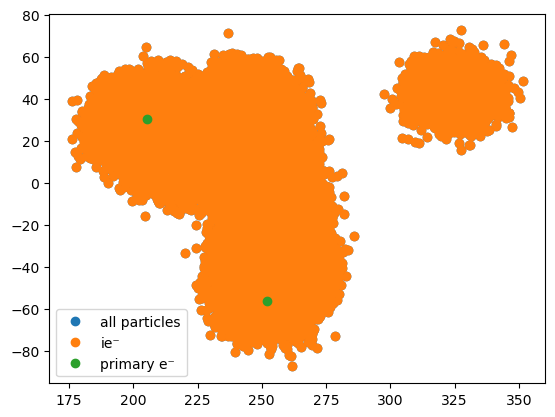

In [22]:
plt.plot(bb_dst_particle.final_x, bb_dst_particle.final_y, 'o', label = 'all particles')
plt.plot(bb_ie.final_x, bb_ie.final_y, 'o', label = 'ie⁻')
plt.plot(bb_dst_particle.loc[bb_dst_particle.primary == 1].final_x, 
         bb_dst_particle.loc[bb_dst_particle.primary == 1].final_y, 'o', label = 'primary e⁻')
plt.legend()
plt.show()

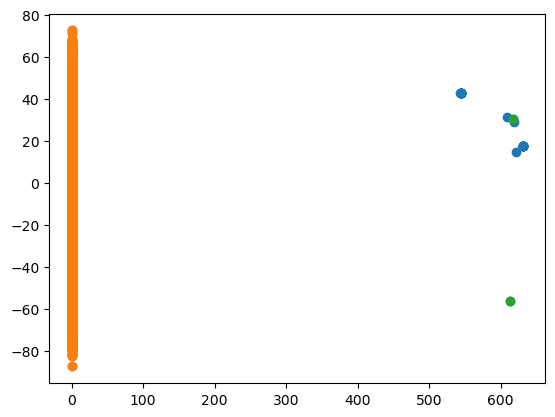

In [23]:
plt.plot(bb_dst_particle.final_z, bb_dst_particle.final_y, 'o')
plt.plot(bb_ie.final_z, bb_ie.final_y, 'o')
plt.plot(bb_dst_particle.loc[bb_dst_particle.primary == 1].final_z, 
         bb_dst_particle.loc[bb_dst_particle.primary == 1].final_y, 'o')
plt.show()

In [24]:
sens_id, part_id = 244, 242

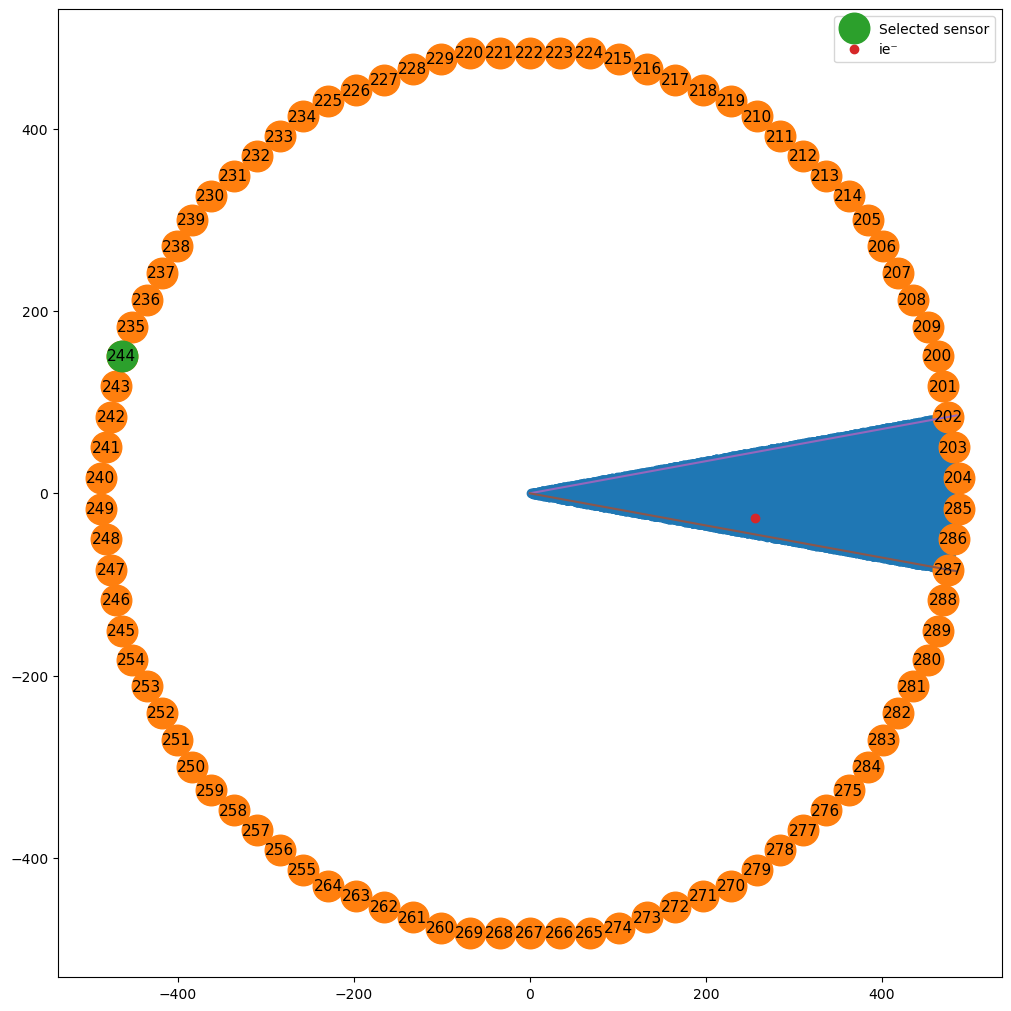

In [25]:
xx = xx_dict[part_id]
yy = yy_dict[part_id]
alpha = np.arctan2(yy, xx)

sens_map(sens_id)

plt.plot(xx, yy, 'o', label = 'ie⁻')

active_diam = 984 # [mm]
radius = np.linspace(0, active_diam/2, 100)
rot = find_rot(alpha)

xx_ = radius*np.cos(dtheta/2 + dtheta*(rot))
plt.plot(xx_ , xx_*np.tan(dtheta/2 + dtheta*(rot)))

xx_ = radius*np.cos(-dtheta/2 + dtheta*(rot))
plt.plot(xx_ , xx_*np.tan(-dtheta/2 + dtheta*(rot)))

plt.legend()
plt.show()

In [ ]:
%%timeit
s2_dict = {}

time_data = np.array(list(tt_dict.values()))

for jj, sens_id in enumerate(sens_fibers.sensor_id[:]):
    
    print(f'Sensor {jj}/{n_sensors}')
    table_id = f'sens_{sens_id}'

    s2_data = vect_find_s2(sens_id, bb_ie['particle_id'])


    # Create the DataFrame after the loop using a dictionary
    table_data = pd.DataFrame({'time': time_data, 's2': s2_data})
    s2_dict[table_id] = table_data


In [ ]:
# Save the 3D dictionary using HDF5 format
with h5py.File('../data/20231025_NEXT100_full_mapping/20231218_bb0nu_s2_signal.h5', 'w') as file:
    for table_id, table_data in s2_dict.items():
        file.create_dataset(table_id, data=table_data.values)